## Imports Libraries and Tools

In [29]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
import matplotlib.pyplot as plt  # For plotting images and results
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # For loading images
from tensorflow.keras.models import Sequential, load_model  # For building and loading the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize

## Load Datasets

In [5]:
# Directories for training and testing data
train_dir = '../data/Training'
test_dir = '../data/Testing'

# Load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

# Shuffle the training data
train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

# Load and shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

# Shuffle the test data
test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

In [6]:
print(f"Total training images: {len(train_paths)} \n")
print(train_paths[: 5],'\n')  # Display first 5 training image paths
print(f"Total testing images: {len(test_paths)} \n")
print(test_paths[: 5],'\n')  # Display first 5 testing image paths

Total training images: 5712 

['../data/Training\\meningioma\\Tr-me_0379.jpg', '../data/Training\\notumor\\Tr-no_0609.jpg', '../data/Training\\glioma\\Tr-gl_0561.jpg', '../data/Training\\pituitary\\Tr-pi_1210.jpg', '../data/Training\\pituitary\\Tr-pi_1205.jpg'] 

Total testing images: 1311 

['../data/Testing\\pituitary\\Te-pi_0109.jpg', '../data/Testing\\pituitary\\Te-pi_0061.jpg', '../data/Testing\\glioma\\Te-gl_0198.jpg', '../data/Testing\\meningioma\\Te-me_0275.jpg', '../data/Testing\\meningioma\\Te-me_0031.jpg'] 



## Data Visualization

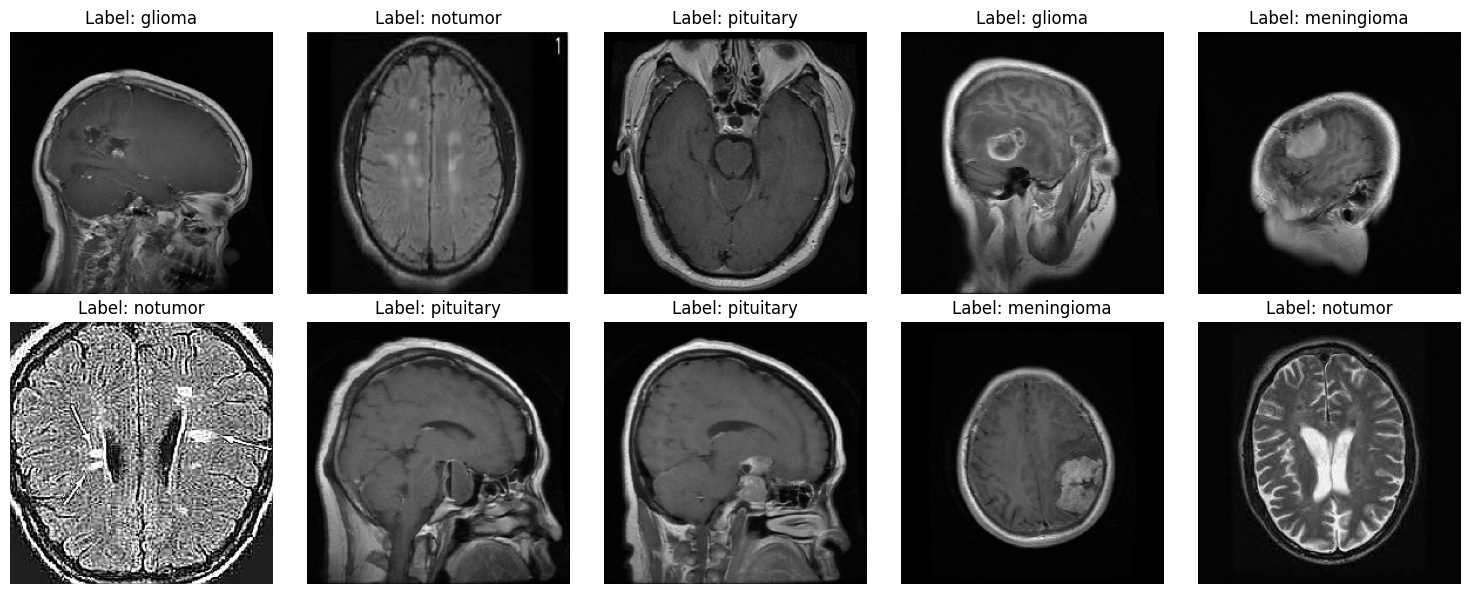

In [7]:
# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axis = plt.subplots(2, 5, figsize=(15, 6))
axis = axis.flatten()

# Load and display images with their labels
for i, idx in enumerate(random_indices):
    img = load_img(train_paths[idx], target_size=(224, 224))
    axis[i].imshow(img)
    axis[i].set_title(f"Label: {train_labels[idx]}")
    axis[i].axis('off')

plt.tight_layout()
plt.show()



## Data Preprocessing

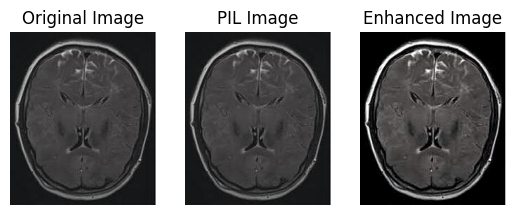

In [8]:
# Image Contrast Enhancement Example

import cv2 as cv

path = '../data/Training/notumor/Tr-no_0609.jpg' # Example image path
image = cv.imread(path) # Load image using OpenCV
image = np.clip(image, 0, 255) # Ensure pixel values are in valid range
image = image.astype(np.uint8) # Convert to uint8 type
image_obj = Image.fromarray(np.uint8(image)) # Convert to PIL Image
image_enh = ImageEnhance.Contrast(image_obj).enhance(random.uniform(.8, 3.5)) # Enhance contrast

# Display the original and enhanced images
plt.subplot(1,3,1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_obj)
plt.title('PIL Image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(image_enh)
plt.title('Enhanced Image')
plt.axis('off')

plt.show()

In [9]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image


# Load images and apply augmentation
def open_images(image_paths):
    images = []
    for path in image_paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Load test images (no augmentation, just resize and normalize)
def open_test_images(image_paths):
    images = []
    for path in image_paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
        images.append(image)
    return np.array(images)


# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = sorted(os.listdir(train_dir))
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def data_generator(image_paths, labels, batch_size=8):
    while True:
        for i in range(0, len(image_paths), batch_size):
            yield (
                open_images(image_paths[i:i+batch_size]),
                encode_label(labels[i:i+batch_size])
            )




## Model Building and Training

In [10]:
# Load the pre-trained VGG16 model without the top layers
IMAGE_SIZE = 128
base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build the model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(os.listdir(train_dir)), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Train the model
batch_size = 4
steps = len(train_paths) // batch_size

history = model.fit(
    data_generator(train_paths, train_labels, batch_size),
    steps_per_epoch=steps,
    epochs=5
)


Epoch 1/5
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 183s 126ms/step - loss: 1.0988 - sparse_categorical_accuracy: 0.5404
Epoch 2/5
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 142s 100ms/step - loss: 0.8031 - sparse_categorical_accuracy: 0.6871
Epoch 3/5
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 144s 101ms/step - loss: 0.6862 - sparse_categorical_accuracy: 0.7351
Epoch 4/5
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 144s 101ms/step - loss: 0.6244 - sparse_categorical_accuracy: 0.7600
Epoch 5/5
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 137s 96ms/step - loss: 0.5877 - sparse_categorical_accuracy: 0.7749


In [11]:
# Fine-tuning the model by unfreezing some layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last convolutional block
for layer in base_model.layers:
    if "block5" in layer.name:
        layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Continue training the model
fine_tune_epochs = 3
history_fine = model.fit(
    data_generator(train_paths, train_labels, batch_size=8),
    steps_per_epoch=steps,
    epochs=fine_tune_epochs
)


Epoch 1/3
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 368s 256ms/step - loss: 0.3372 - sparse_categorical_accuracy: 0.8718
Epoch 2/3
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 356s 249ms/step - loss: 0.1728 - sparse_categorical_accuracy: 0.9339
Epoch 3/3
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 352s 247ms/step - loss: 0.1084 - sparse_categorical_accuracy: 0.9613


## Train and Val Plots

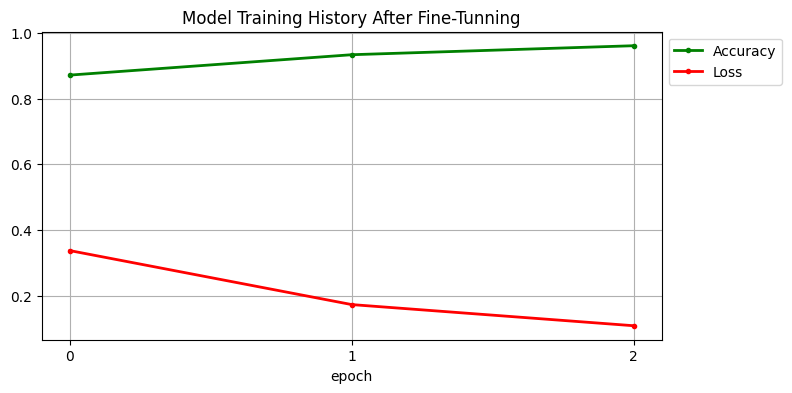

In [12]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history_fine.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history_fine.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History After Fine-Tunning')
plt.xlabel('epoch')
plt.xticks([x for x in range(3)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Model Classification Report

In [13]:
# 1. Prediction on test data
test_images = open_test_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 584ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       300
           1       0.90      0.96      0.93       306
           2       0.99      1.00      0.99       405
           3       0.99      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



## Model Confusion Plot

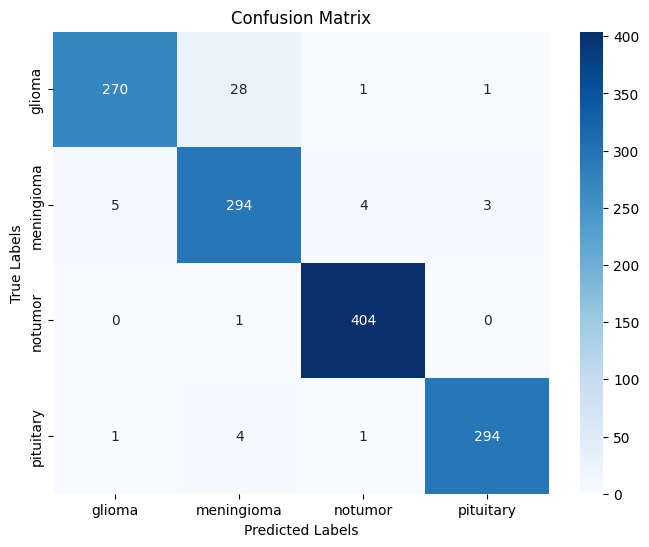

In [14]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Roc Curve Plot

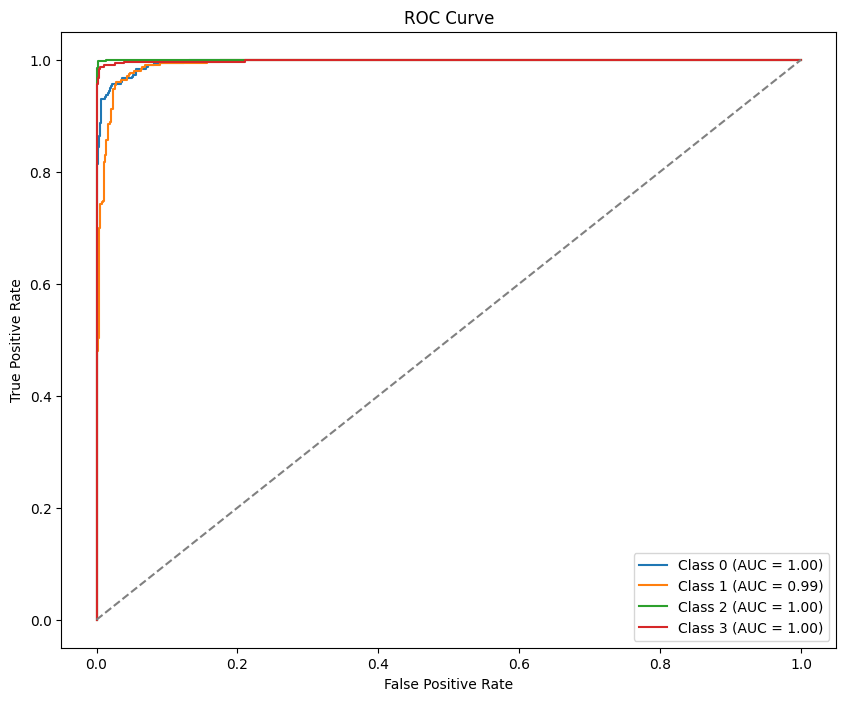

In [15]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


## Save & Load Model

In [16]:
# Save the entire model
model.save('../models/model.h5')

In [19]:
# Load the trained model
model = load_model('../models/model.h5')

## MRI Tumor Detection System

In [21]:
unique_labels = sorted(os.listdir(train_dir))
unique_labels

['glioma', 'meningioma', 'notumor', 'pituitary']

In [22]:
# Class labels
class_labels = unique_labels

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

## Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


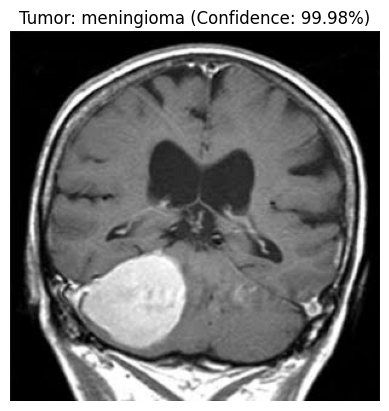

In [32]:
# Example usage
image_path = '../data/Testing/meningioma/Te-me_0020.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


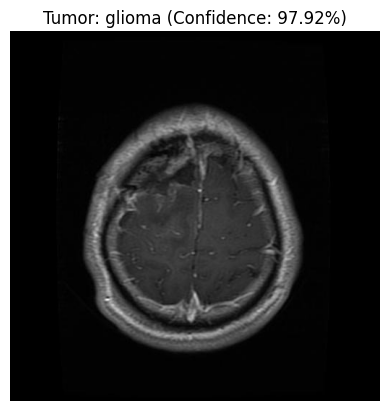

In [30]:
# Example usage
image_path = '../data/Testing/glioma/Te-gl_0017.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


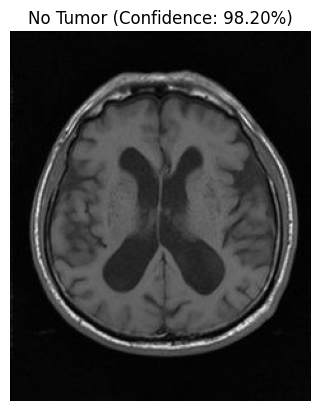

In [33]:
# Example usage
image_path = '../data/Testing/notumor/Te-no_0022.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)